In [1]:
import scanpy as sc
import numpy as np

import random
import torch
import sklearn
import os
def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
adata=sc.read_h5ad("./data/t1d.h5ad")
print(adata)
print(adata.X[:10,:10])

AnnData object with n_obs × n_vars = 69645 × 26099
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'disease_state', 'cell_label', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'
  (0, 1)	1.076574683189392
  (3, 1)	0.6022599935531616
  (4, 1)	0.32389

In [5]:
import pandas as pd
df = pd.DataFrame(adata.obs[['disease_state','donor_id']].copy())

# Remove duplicated rows
unique_df = df.drop_duplicates()

# Construct a dictionary mapping the first column to the second column
mapping_dict = dict(zip(unique_df['donor_id'], unique_df['disease_state']))

print("Unique DataFrame:")
print(unique_df)
print("\nMapping Dictionary:")
print(mapping_dict)

Unique DataFrame:
                    disease_state donor_id
AAACCTGAGGTGTGGT-1        Control  HPAP022
AAACCTGCACCTTGTC-2        Control  HPAP026
AAACGGGAGTAGCGGT-3        Control  HPAP034
AAACCTGCAGCTGTAT-4        Control  HPAP035
AAACCTGAGACGCAAC-5        Control  HPAP036
AAACCTGCACCAGATT-6        Control  HPAP037
AAACCCAAGGACATCG-7        Control  HPAP039
AAACCCAAGTAGTCAA-8        Control  HPAP040
AAACCCACAACCTAAC-9        Control  HPAP042
AAACGAACAAGCGCTC-10       Control  HPAP044
AAACCCAAGCCTCTGG-11       Control  HPAP047
AAACCTGAGACTGTAA-12           AAB  HPAP019
AAACCTGCAATGGATA-13           AAB  HPAP024
AAACCTGGTTCTGGTA-14           AAB  HPAP029
AAACCCACAGACTCTA-15           AAB  HPAP038
AAACGAAAGAATCGTA-16           AAB  HPAP043
AAACCCAAGACCATAA-17           AAB  HPAP045
AAACCCAAGCGCGTTC-18           AAB  HPAP049
AAACCCACAGTATTCG-19           AAB  HPAP050
AAACCTGAGGCACATG-20           T1D  HPAP020
AAACCTGAGCGTTGCC-21           T1D  HPAP021
AAACCTGCATCCTAGA-22           T1D  H

# Condition label permutation for each donor_id

Permute the condition label for each donor_id

In [7]:
# Extract keys and values
keys = list(mapping_dict.keys())
values = list(mapping_dict.values())
# Shuffle the values
random.shuffle(values)
# Create a new dictionary with permuted values
permuted_dict = dict(zip(keys, values))
print(permuted_dict)

{'HPAP022': 'Control', 'HPAP026': 'AAB', 'HPAP034': 'Control', 'HPAP035': 'Control', 'HPAP036': 'T1D', 'HPAP037': 'AAB', 'HPAP039': 'AAB', 'HPAP040': 'AAB', 'HPAP042': 'Control', 'HPAP044': 'Control', 'HPAP047': 'Control', 'HPAP019': 'T1D', 'HPAP024': 'AAB', 'HPAP029': 'AAB', 'HPAP038': 'T1D', 'HPAP043': 'T1D', 'HPAP045': 'Control', 'HPAP049': 'Control', 'HPAP050': 'AAB', 'HPAP020': 'Control', 'HPAP021': 'Control', 'HPAP023': 'Control', 'HPAP028': 'AAB', 'HPAP032': 'T1D'}


In [8]:
disease_state_fake=[]
for i in range(adata.shape[0]):
    disease_state_fake.append(permuted_dict[adata.obs["donor_id"][i]])
adata.obs['disease_state_fake']=np.array(disease_state_fake)

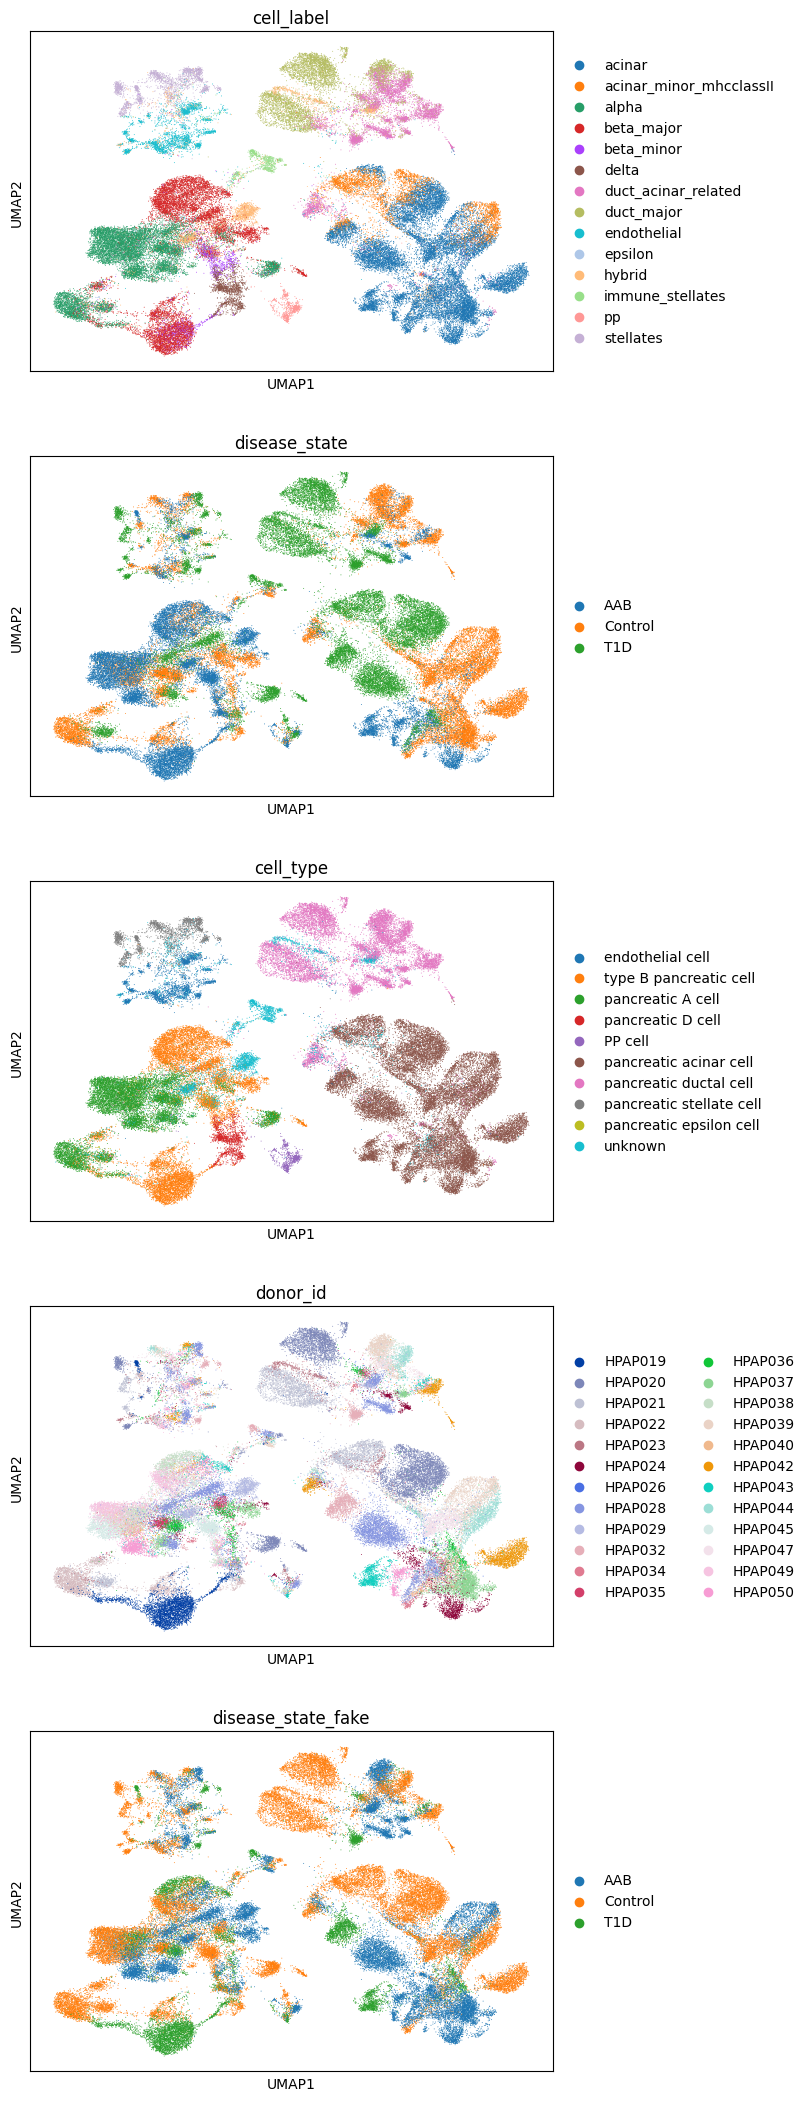

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]]
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["cell_label","disease_state","cell_type","donor_id",'disease_state_fake'],ncols=1)

In [ ]:
from ndreamer import NDreamer

model = NDreamer(adata, condition_key="disease_state_fake", contorl_name='Control', num_hvg=2000, require_batch=True,
                            batch_key='donor_id',
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=2048, epoches=10, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./t1d_fake/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./t1d_fake/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

# Now we evaluate this fake dataset

In [ ]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os

from metrics import calculate_metrics

def calculate_mean_proportion_matrix(df):
    """
    Calculates the mean proportion for each combination of condition and neighbor
    and summarizes the result in a square matrix dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe with columns ['condition', 'neighbor', 'proportion'].

    Returns:
    pd.DataFrame: A square matrix dataframe where rows represent 'condition' and columns represent 'neighbor'.
    """
    # Use a pivot table to calculate the mean proportions
    mean_matrix = df.pivot_table(
        index='condition',
        columns='neighbor',
        values='proportion',
        aggfunc='mean',
        fill_value=0  # Replace NaN with 0 if there are missing combinations
    )

    return mean_matrix

def calculate_rowwise_correlation(adata1, adata2, batch_key="batch_all_with_condition"):
    # Ensure the obs index and batch_key match
    #assert np.sum(adata1.obs["batch_all_with_condition"]!=adata2.obs["batch_all_with_condition"])==0, "obs indices do not match between the two AnnData objects"
    assert batch_key in adata1.obs.columns, f"{batch_key} not found in adata1.obs"
    assert batch_key in adata2.obs.columns, f"{batch_key} not found in adata2.obs"

    results = []

    # Iterate through unique batches
    unique_batches = adata1.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the data for the current batch
        batch_mask = adata1.obs[batch_key] == batch
        data1 = adata1[batch_mask].X
        data2 = adata2[batch_mask].X
        
        barcodes=adata1[batch_mask].obs_names.tolist()

        # Ensure the data is in dense format if sparse
        if not isinstance(data1, np.ndarray):
            data1 = data1.toarray()
        if not isinstance(data2, np.ndarray):
            data2 = data2.toarray()

        # Compute correlation for each row
        for i in range(data1.shape[0]):
            row_corr = np.corrcoef(data1[i, :], data2[i, :])[0, 1]
            mse=np.mean(np.square(data1[i, :]-data2[i, :]))
            results.append({"correlation": row_corr, batch_key: batch, "barcode":barcodes[i], "mse":mse})

    # Convert results to DataFrame
    result_df = pd.DataFrame(results)
    return result_df


def extract_de_results(adata, batch_key, cell_type_key, key_added="DE_wilcoxon", min_cells=30):
    results = []

    # Iterate through unique batches
    unique_batches = adata.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the AnnData for the current batch
        adata_batch = adata[adata.obs[batch_key] == batch]

        # Filter out cell types with fewer than `min_cells` cells
        cell_counts = adata_batch.obs[cell_type_key].value_counts()
        valid_cell_types = cell_counts[cell_counts >= min_cells].index

        # Subset the AnnData object to only include valid cell types
        adata_batch = adata_batch[adata_batch.obs[cell_type_key].isin(valid_cell_types)]

        # Skip the batch if there are no valid cell types
        if adata_batch.shape[0] == 0 or len(valid_cell_types) == 0:
            continue

        # Perform DE analysis
        sc.tl.rank_genes_groups(adata_batch, groupby=cell_type_key, method='wilcoxon', key_added=key_added, use_raw=False)

        # Extract DE results for each valid cell type
        for cell_type in valid_cell_types:
            # Extract adjusted p-values and gene names
            gene_names = adata_batch.uns[key_added]['names'][cell_type]
            pvals_adj = adata_batch.uns[key_added]['pvals_adj'][cell_type]

            # Create a dictionary for the current cell type and batch
            row_data = {
                "cell_type_key": cell_type,
                "batch_all_with_condition": batch,
            }
            # Add adjusted p-values for each gene as separate columns
            row_data.update({gene: pval for gene, pval in zip(gene_names, pvals_adj)})
            results.append(row_data)

    # Convert results to a DataFrame
    result_df = pd.DataFrame(results)
    return result_df

In [ ]:
def evaluate_ndreamer_batch(dataset_name, cell_type_key, batch_key, condition_key):
    print("adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    adata = sc.read_h5ad("./" + dataset_name + "/adata.h5ad")
    adata.raw = None

    if isinstance(batch_key, str):
        batch_key = [batch_key]

    batch_all = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all.append(tmp)
    batch_all = np.array(batch_all)
    adata.obs["batch_all"] = batch_all
    adata.obs["batch_all"] = adata.obs["batch_all"].astype("category")
    print("batch_all", np.unique(batch_all))

    batch_all_with_condition = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + adata.obs[condition_key][i]
        batch_all_with_condition.append(tmp)
    batch_all_with_condition = np.array(batch_all_with_condition)
    adata.obs["batch_all_with_condition"] = batch_all_with_condition
    adata.obs["batch_all_with_condition"] = adata.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition", np.unique(batch_all_with_condition))
    
    main_effect_adata = ad.AnnData(adata.obsm['X_effect_modifier_space_PCA'], dtype=np.float32)
    main_effect_adata.obs = adata.obs.copy()

    integrated = []
    for filei in os.listdir("./" + dataset_name):
        if filei.find("expression.h5ad") > 0:
            integrated.append(sc.read_h5ad("./" + dataset_name + "/" + filei))
    integrated = ad.concat(integrated, merge="same", uns_merge="same")

    # Process `batch_all` for denoised data
    batch_all_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all_denoise.append(tmp)
    batch_all_denoise = np.array(batch_all_denoise)
    integrated.obs["batch_all"] = batch_all_denoise
    integrated.obs["batch_all"] = integrated.obs["batch_all"].astype("category")
    print("batch_all_denoise", np.unique(batch_all_denoise))

    # Process `batch_all_with_condition` for denoised data
    batch_all_with_condition_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + integrated.obs[condition_key][i]
        batch_all_with_condition_denoise.append(tmp)
    batch_all_with_condition_denoise = np.array(batch_all_with_condition_denoise)
    integrated.obs["batch_all_with_condition"] = batch_all_with_condition_denoise
    integrated.obs["batch_all_with_condition"] = integrated.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition_denoise", np.unique(batch_all_with_condition_denoise))

    batch_key.append("batch_all")
    batch_key.append("batch_all_with_condition")
    print("Finish preprocess")

    print("Calculating global distortion...")
    df_global_correlation = calculate_rowwise_correlation(adata, integrated)
    df_global_correlation.to_csv("./evaluate/" + dataset_name + "_global_correlation.csv")
    print("Finish")

    print("Evaluate gene-level signal distortion")
    real_data_DE = extract_de_results(adata=adata, batch_key="batch_all_with_condition", cell_type_key=cell_type_key,
                                      key_added="DE_wilcoxon")
    denoised_DE = extract_de_results(adata=integrated, batch_key="batch_all_with_condition",
                                     cell_type_key=cell_type_key, key_added="DE_wilcoxon")
    real_data_DE.to_csv("./evaluate/" + dataset_name + "_real_DE.csv")
    denoised_DE.to_csv("./evaluate/" + dataset_name + "_denoised_DE.csv")
    print("Finish")

    '''res = cnova.utils.calc_oobNN(integrated, batch_key="batch_all_with_condition", condition_key=condition_key)
    df = res.obsm['knn_prop']
    df['condition'] = res.obs[condition_key]
    df.index.name = "index"

    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./evaluate/" + dataset_name + "_oobNN.csv")'''
    
    print("Plot of main effect:")
    if main_effect_adata.shape[1] > 60:
        sc.pp.pca(main_effect_adata)
    else:
        main_effect_adata.obsm['X_pca'] = main_effect_adata.X.copy()
    sc.pp.neighbors(main_effect_adata, n_neighbors=15)
    sc.tl.umap(main_effect_adata)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(main_effect_adata, color=colori, ncols=1)

    print("Plot of denoised expression")
    sc.pp.pca(integrated)
    sc.pp.neighbors(integrated, n_neighbors=15)
    sc.tl.umap(integrated)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(integrated, color=colori, ncols=1)
    print("Finish adata preprocessing", "=" * 20)
    
    print("Batch effect:")
    print("condition-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key=condition_key,
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("batch-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key="batch_all",
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("batch-condition-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key="batch_all_with_condition",
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("Within each unique condition, evaluate the batch effect of the denoised expression")
    unique_conditions=np.unique(np.array(integrated.obs[condition_key]))
    for conditioni in unique_conditions:
        print("Within each unique condition, evaluate the batch effect of the denoised expression")
        print("Now evaluating",conditioni)
        integratedi=integrated[integrated.obs[condition_key]==conditioni]
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(integratedi, batch_key="batch_all",
                          celltype_key=cell_type_key, all=True, n_neighbors=15)
        for colori in ["batch_all",cell_type_key]:
            sc.pl.umap(integratedi, color=colori, ncols=1)
        print("*"*20)

    print("Batch-related mixing performance evaluation for main effect:")
    '''
    for batch_keyi in batch_key:
        print("Batch-related mixing performance evaluation for main effect:")
        print(batch_keyi)
        if batch_keyi.find(".")>=0:
            main_effect_adata.obs[batch_keyi.replace(".","_")]=main_effect_adata.obs[batch_keyi].copy()
            batch_keyi=batch_keyi.replace(".","_")
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(main_effect_adata, batch_key=batch_keyi,
                          celltype_key=cell_type_key, all=True, n_neighbors=15)
        print("=" * 20)
    '''
    res = cnova.utils.calc_oobNN(integrated, batch_key="batch_all_with_condition", condition_key=condition_key)
    df = res.obsm['knn_prop']
    df['condition'] = res.obs[condition_key]
    df.index.name = "index"

    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./evaluate/" + dataset_name + "_oobNN.csv")

    g = sea.FacetGrid(df, col='neighbor', hue='condition')
    g.map(sea.kdeplot, 'proportion', bw_adjust=2, alpha=1)
    g.set(xlabel='NN proportion', ylabel='Density')
    g.add_legend()
    plt.suptitle('NDreamer integration')
    sea.set_style('white')
    plt.show()

    df_summarize = calculate_mean_proportion_matrix(df)
    print(df_summarize)
    df_summarize.to_csv("./evaluate/" + dataset_name + "_summary.csv", index=False)

In [ ]:
dataset_names=["t1d_fake","t1d_fake_all"]
cell_type_keys=["cell_type","cell_type"]
batch_keys=["donor_id","donor_id_permute"]
condition_keys=["disease_state_fake","disease_state_permute"]

In [ ]:
i=0
evaluate_ndreamer_batch(dataset_name=dataset_names[i],cell_type_key=cell_type_keys[i],batch_key=batch_keys[i],condition_key=condition_keys[i])